In [34]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
import numpy as np
import matplotlib.pyplot as plt
import sys
import json
from numpy import linalg as LA

import tensorflow as tf

import getpass
ui = getpass.getuser()
if ui == 'laura':
    p = '/home/laura'
elif ui == 'lauradriscoll':
    p = '/Users/lauradriscoll/Documents'

net = 'stepnet'
PATH_YANGNET = os.path.join(p,'code/multitask-nets',net) 

sys.path.insert(0, PATH_YANGNET)

from task import generate_trials, rule_name, rule_index_map, rules_dict
from network import Model
from tools_lnd import name_best_ckpt, gen_trials_from_model_dir, get_stim_cats, take_names
from task import generate_trials, rule_name
import tools

In [35]:
figpath = os.path.join(p,'code','overleaf','multitask-nets','v4_figs','paper_figs','supp','armnet_task_schematic')
if not os.path.exists(figpath):
    os.makedirs(figpath)

In [36]:
def load_X_from_model_dir(model_dir,rule, mode = 'test',noise = False,alpha_mod1 = 0):    
    model = Model(model_dir)
    with tf.Session() as sess:
        model.restore()
        hparams = model.hp
        trial = generate_trials(rule, hparams, mode=mode, batch_size = 20, noise_on=noise, delay_fac =1,alpha_mod1 = alpha_mod1)
        feed_dict = tools.gen_feed_dict(model, trial, hparams)
        h_tf, y_hat = sess.run([model.h, model.y_hat], feed_dict=feed_dict) #(n_time, n_condition, n_neuron)
            
    return h_tf, y_hat, hparams, trial
    
def plot_epoch_division_nolabel(ax, trial, y_lim, plot_label = False):
    for e in trial.epochs.keys():
        if plot_label ==True:
            e_name ,_ ,_ ,_ = take_names(e,'fdgo')
            ax.text(10*np.max([trial.epochs[e][0],0])+20,1.2,e_name,rotation = 0,fontsize = 14)
        if trial.epochs[e][1]>0:
            ax.plot([10*(trial.epochs[e][1]-1),10*(trial.epochs[e][1]-1)],[-1.8,1.8],':k',linewidth = 2,alpha = .5)
    ax.set_ylim((y_lim[0]-1,y_lim[1]+1))


In [56]:
task_list = ['fdgo', 'reactgo', 'delaygo', 'fdanti', 'reactanti', 'delayanti',
              'delaydm1', 'delaydm2', 'contextdelaydm1', 'contextdelaydm2', 'multidelaydm',
              'dmsgo', 'dmsnogo', 'dmcgo', 'dmcnogo']

rule_set_names = ['DelayGo', 'ReactGo', 'MemoryGo', 'DelayAnti', 'ReactAnti', 'MemoryAnti',
              'Decison1', 'Decison2', 'ContextDecison1', 'ContextDecison2', 'MultiDecison',
              'DelayDecison1', 'DelayDecison2', 'ContextDelayDecison1', 'ContextDelayDecison2', 'MultiDelayDecison',
              'DelayMatch2SampleGo', 'DelayMatch2SampleNogo', 'DelayMatch2CategoryGo', 'DelayMatch2CategoryNoGo']

data_folder = os.path.join('data/rnn/multitask/',net,'final')
rnn_type = 'LeakyRNN'
activation = 'softplus'
init = 'diag'
seed = '5'
n_rnn = str(256)
l2w = -6
l2h = -6
l1w = 0
l1h = 0
lr = -7
ruleset = 'arm'

s = '_'
rule_trains_str = s.join(task_list)
net_name = 'lr'+"{:.1f}".format(-lr)+'l2_w'+"{:.1f}".format(-l2w)+'_h'+"{:.1f}".format(-l2h)+'_'+rule_trains_str

transfer_m = os.path.join(data_folder,ruleset,rnn_type,activation,init,
                          str(len(task_list))+'_tasks',str(n_rnn)+'_n_rnn',net_name,seed)

m = os.path.join(p,transfer_m)

In [57]:
rules_dict['all']

['fdgo',
 'reactgo',
 'delaygo',
 'fdanti',
 'reactanti',
 'delayanti',
 'delaydm1',
 'delaydm2',
 'contextdelaydm1',
 'contextdelaydm2',
 'multidelaydm',
 'dmsgo',
 'dmsnogo',
 'dmcgo',
 'dmcnogo']

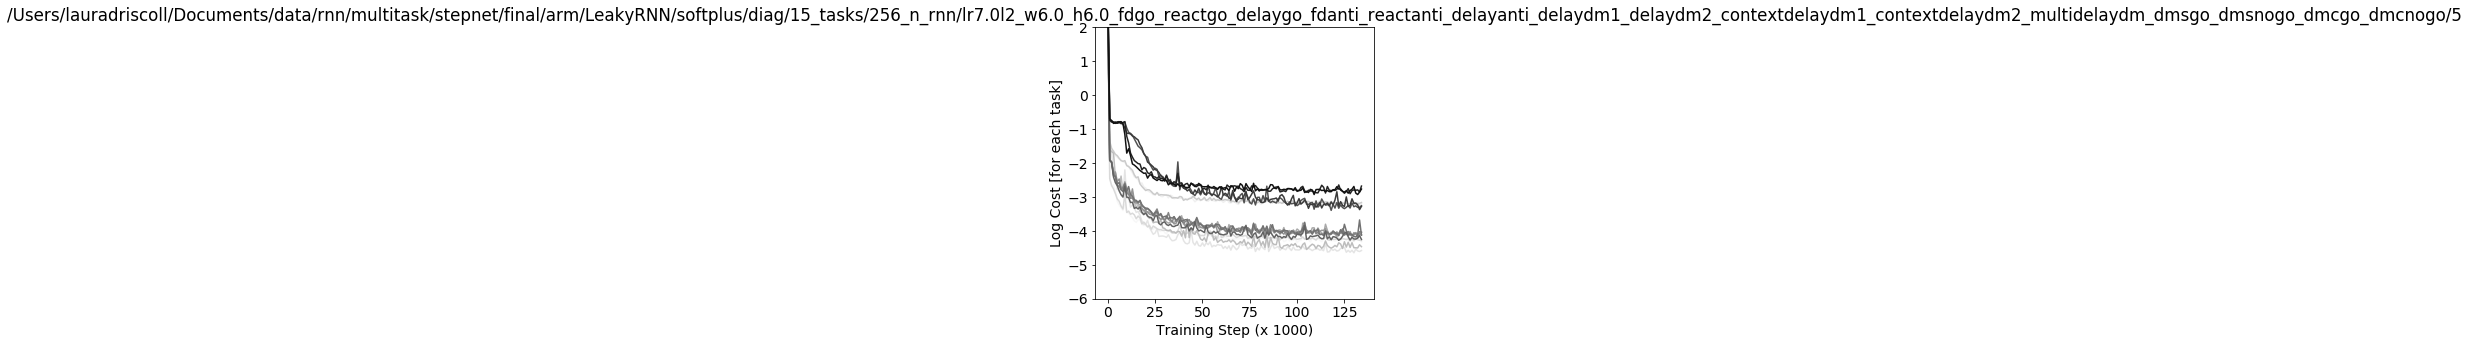

In [58]:
rule_trains = rules_dict['all']
fig = plt.figure(figsize=(5, 5))
cmap=plt.get_cmap('Greys')
fname = os.path.join(m, 'log.json')

with open(fname, 'r') as f:
    log_all = json.load(f)
for ri in range(len(rule_trains)):
    r = rule_trains[ri]
    c = cmap((ri+1)/(len(rule_trains)+1))
    ax = fig.add_subplot(1,1,1)
    x = np.log(log_all['cost_'+r])
    plt.plot(x,'-',c = c)
    ax.set_xlabel('Training Step (x 1000)')
    ax.set_ylabel('Log Cost [for each task]')
    plt.ylim([-6,2])
    
plt.title(m)
plt.show()    

In [59]:
def make_axes_nice(ax,t_len,x_ax_label=False,plot_divisions=True,ylims = [-1,1],label = [],label_y = -1):
    ax.spines["top"].set_visible(False)  
    ax.spines["right"].set_visible(False)
    ax.spines['left'].set_position(('outward', 10))
    ax.spines['bottom'].set_position(('outward', 10))
    
    #all xlims are the same
    ax.set_xlim([0,t_len]) 
    
    #set ylims
    ax.spines['left'].set_bounds(ylims[0],ylims[1])
    ax.set_ylim((ylims[0]-.3,ylims[1]+.3))
    ax.set_yticks((ylims[0],ylims[1]))
    
    if x_ax_label==False:
        ax.spines["bottom"].set_visible(False)
        ax.set_xticks([]) 
    else:
        ax.set_xlabel('Time (ms)')
        
    if plot_divisions==True:
        if label=='Fixation':
            plot_label = True
        else:
            plot_label = False
                
        plot_epoch_division_nolabel(ax, trial_f, ylims, plot_label=plot_label)
        
    ax.text(0,label_y,label, fontsize=14, fontweight='bold')
        
        

0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(276, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 7) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(7,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/arm/LeakyRNN/softplus/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/5/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/arm/LeakyRNN/softplus/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/5/model.ckpt
0.158113883008419
Variables being optimized:
<tf

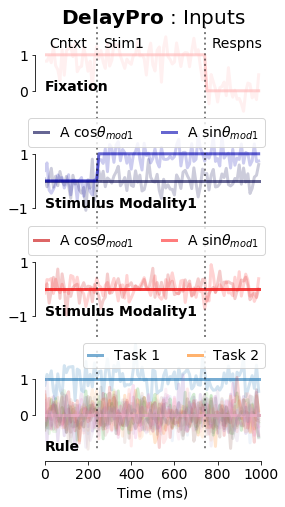

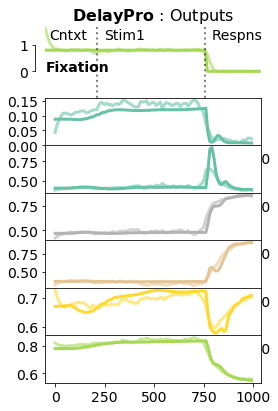

In [60]:
cmap=plt.get_cmap('terrain')
plt.rcParams.update({'font.size': 14})
a = .6
t = 0
lw = 3
# n = True
nr = 4
nc = 1

rule = 'fdgo'
    
h, y_hat, hparams, trial_n = load_X_from_model_dir(m,rule,noise = True)
stim_in = hparams['n_eachring']*hparams['num_ring']

#MAKE INTPUT FIGS
fig = plt.figure(figsize=(3*nc, 1.5*nr))
ax1 = fig.add_axes([0,.75,1,.25])

##colorset for stim
cmap=plt.get_cmap('seismic')
big_stim_in = stim_in+3
c_set = np.arange(0,1,1/big_stim_in)
c_set = np.concatenate((c_set[:int(stim_in/2)],c_set[big_stim_in:int(big_stim_in/2):-1]),axis = 0)
labels = [r'A cos$\theta_{mod1}$',r'A sin$\theta_{mod1}$']

####subplot1
l = 0    
ax1.plot(range(0,np.shape(trial_n.x)[0]*10,10),trial_n.x[:,t,l], alpha = a/3, linewidth = lw,c = cmap(c_set[l-1]))
h, _, _, trial_f = load_X_from_model_dir(m,rule,noise = False)
ax1.plot(range(0,np.shape(trial_f.x)[0]*10,10),trial_f.x[:,t,l], 'C0', alpha = a, linewidth = lw,c = cmap(c_set[l-1]))
t_len = 10*np.shape(trial_f.x)[0]
make_axes_nice(ax1,t_len,x_ax_label=False,plot_divisions=True,ylims = [0,1],label = 'Fixation',label_y = 0)

####subplot2
ax2 = fig.add_axes([0,.5,1,.25])
for l in range(2):
    plt.plot(range(0,np.shape(trial_n.x)[0]*10,10),trial_n.x[:,t,1+l], alpha = a/3, linewidth = lw,c = cmap(c_set[l]))#,c = cmap(c_set[l])
    plt.plot(range(0,np.shape(trial_f.x)[0]*10,10),trial_f.x[:,t,1+l], alpha = a, linewidth = lw,c = cmap(c_set[l]),label = labels[l])#,c = cmap(c_set[l])

make_axes_nice(ax2,t_len,x_ax_label=False,plot_divisions=True,label = 'Stimulus Modality1',label_y = -1)
plt.legend(fontsize = 14,loc = 4, bbox_to_anchor=(1.05, .75),handlelength=1,ncol = 2)

####subplot3
ax3 = fig.add_axes([0,.25,1,.25])
for l in range(2):
    plt.plot(range(0,np.shape(trial_n.x)[0]*10,10),trial_n.x[:,t,3+l], alpha = a/3, linewidth = lw,c = cmap(c_set[2+l]))#,c = cmap(c_set[l])
    plt.plot(range(0,np.shape(trial_f.x)[0]*10,10),trial_f.x[:,t,3+l], alpha = a, linewidth = lw,c = cmap(c_set[2+l]), label = labels[l])#,c = cmap(c_set[l])

make_axes_nice(ax3,t_len,x_ax_label=False,plot_divisions=True,label = 'Stimulus Modality1',label_y = -1)
plt.legend(fontsize = 14,loc = 4, bbox_to_anchor=(1.05, .75),handlelength=1,ncol = 2)

###subplot4
ax4 = fig.add_axes([0,0,1,.25])
cmap=plt.get_cmap('tab20')
task_n = 0
for l in range(15):
    plt.plot(range(0,np.shape(trial_n.x)[0]*10,10),trial_n.x[:,t,stim_in+l+1], alpha = a/3, linewidth = lw,c = cmap(l/20))#,c = cmap(l/20)
    if (l%2)==0:
        if l<4:
            task_n+=1
            print(l)
            plt.plot(range(0,np.shape(trial_f.x)[0]*10,10),trial_f.x[:,t,stim_in+l+1], alpha = a, linewidth = lw,c = cmap(l/20),label = 'Task '+ str(int(task_n)))#,c = cmap(l/20)
    elif l==19:
        plt.plot(range(0,np.shape(trial_f.x)[0]*10,10),trial_f.x[:,t,stim_in+l+1], alpha = a, linewidth = lw,c = cmap(l/20),label = '...')#,c = cmap(l/20)
    else:
        plt.plot(range(0,np.shape(trial_f.x)[0]*10,10),trial_f.x[:,t,stim_in+l+1], alpha = a, linewidth = lw,c = cmap(l/20))#,c = cmap(l/20)


make_axes_nice(ax4,t_len,x_ax_label=True,plot_divisions=True,ylims = [0,1],label = 'Rule',label_y = -1)
plt.legend(fontsize = 14, bbox_to_anchor=(1.05, .7), loc=4,handlelength=1,ncol = 3)

_ ,rule_name ,_ ,_ = take_names('fix1',rule)
ax1.set_title(r"$\bf{"+rule_name+"}$"+' : Inputs',fontsize = 20,y = .9)#, fontweight='bold'

#SAVE INPUT FIGS
figname = 'schematic_inputs_'+rule+'.pdf'
if not os.path.exists(figpath):
    os.makedirs(figpath)
plt.savefig(os.path.join(figpath,figname),bbox_inches='tight')

#MAKE OUTPUT FIGS
nr = 4
nc = 1
fig = plt.figure(figsize=(3*nc, 1.1*nr))

##colorset for stim
cmap=plt.get_cmap('Set2')
big_stim_in = stim_in+5
c_set = np.arange(0,1,1/big_stim_in)
c_set = np.concatenate((c_set[:int(stim_in/2)],c_set[big_stim_in:int(big_stim_in/2):-1]),axis = 0)
labels = [r'A cos$\theta_{mod1}$',r'A sin$\theta_{mod1}$']

###subplot6
ax = {}
l = 0
ax[l] = fig.add_axes([0,1-(l*.25),1,.25])
ax[l].plot(range(0,np.shape(trial_f.y)[0]*10,10),trial_f.y[:,t,l],alpha = 1, linewidth = lw,c = cmap(c_set[l-1]))
for l in range(1,np.shape(y_hat)[2]):
    ax[l] = fig.add_axes([0,1-(l*.15),1,.15])
    ax[l].plot(range(0,np.shape(trial_f.y)[0]*10,10),trial_f.y[:,t,l],c = cmap(c_set[l-1]),alpha = 1, linewidth = lw)
# plt.legend(('fixation',r'$\cos{\theta}$',r'$\sin{\theta}$'), bbox_to_anchor=(-.16,1.2), 
#            loc="upper left",fontsize = 14,ncol = 3,handlelength=1)

##subplot5
l = 0
ax[l].plot(range(0,np.shape(trial_f.x)[0]*10,10),y_hat[:,t,l],alpha = a, linewidth = lw,c = cmap(c_set[l-1]))
for l in range(1,np.shape(y_hat)[2]):
    ax[l].plot(range(0,np.shape(trial_f.x)[0]*10,10),y_hat[:,t,l],c = cmap(c_set[l-1]),alpha = a, linewidth = lw)
# plt.legend(('fixation',r'$\cos{\theta}$',r'$\sin{\theta}$'), bbox_to_anchor=(-.16,1.2), 
#            loc="upper left",fontsize = 14,ncol = 3,handlelength=1)

label_set = ['Fixation','Response '+ r'$\cos{\theta}$','Response '+r'$\sin{\theta}$']

l = 0
make_axes_nice(ax[l],t_len,x_ax_label=False,plot_divisions=True,ylims = [0,1],label = label_set[l],label_y = 0)

l = 1
# make_axes_nice(ax[l],t_len,x_ax_label=False,plot_divisions=True,ylims = [-1,1],label = label_set[l],label_y = -1)

l = 2
# make_axes_nice(ax[l],t_len,x_ax_label=True,plot_divisions=True,ylims = [-1,1],label = label_set[l],label_y = -1)

ax[0].set_title(r"$\bf{"+rule_name+"}$"+' : Outputs' ,fontsize = 16,y = .9)#, fontweight='bold'

#SAVE OUTPUT FIGS
figname = 'schematic_output_'+rule+'.pdf'
if not os.path.exists(figpath):
    os.makedirs(figpath)
plt.savefig(os.path.join(figpath,figname),bbox_inches='tight')

stim1
go1
fix1
stim1
go1
fix1
stim1
go1
fix1
stim1
go1
fix1
stim1
go1
fix1
stim1
go1
fix1
stim1
go1
fix1
stim1
go1
fix1
stim1
go1
fix1
stim1
go1
fix1
stim1
go1
fix1
stim1
go1
fix1
stim1
go1
fix1
stim1
go1
fix1
stim1
go1
fix1
stim1
go1
fix1
stim1
go1
fix1
stim1
go1
fix1
stim1
go1
fix1
stim1
go1
fix1


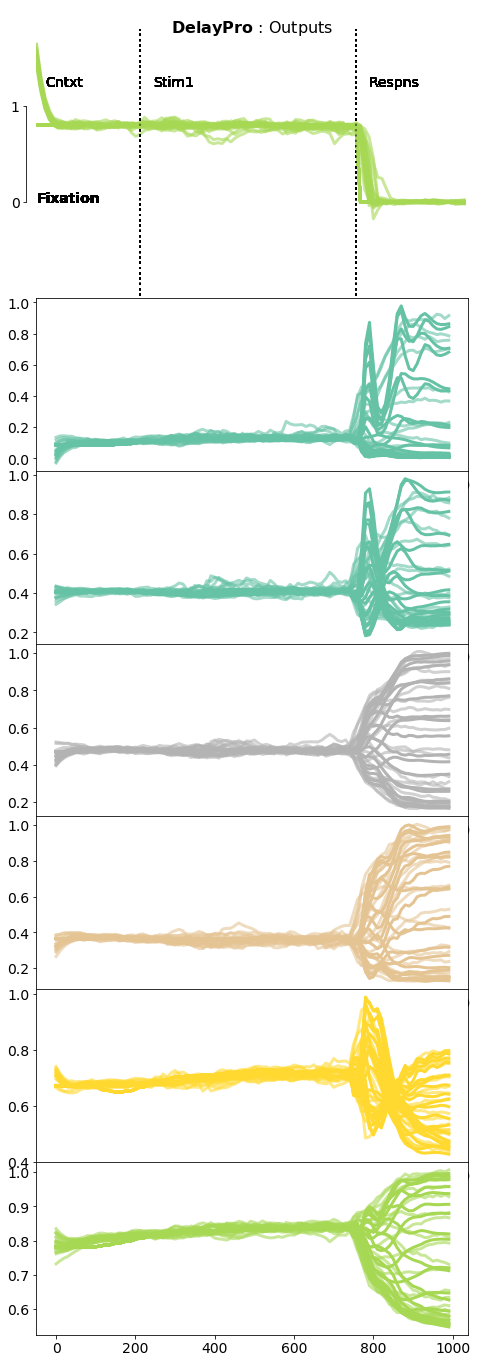

In [61]:

#MAKE OUTPUT FIGS
nr = 4
nc = 1
fig = plt.figure(figsize=(6*nc, 4*nr))
    
for t in range(0,80,4):

    ##colorset for stim
    cmap=plt.get_cmap('Set2')
    big_stim_in = stim_in+5
    c_set = np.arange(0,1,1/big_stim_in)
    c_set = np.concatenate((c_set[:int(stim_in/2)],c_set[big_stim_in:int(big_stim_in/2):-1]),axis = 0)
    labels = [r'A cos$\theta_{mod1}$',r'A sin$\theta_{mod1}$']

    ###subplot6
    ax = {}
    l = 0
    ax[l] = fig.add_axes([0,1-(l*.25),1,.25])
    ax[l].plot(range(0,np.shape(trial_f.y)[0]*10,10),trial_f.y[:,t,l],alpha = 1, linewidth = lw,c = cmap(c_set[l-1]))
    for l in range(1,np.shape(y_hat)[2]):
        ax[l] = fig.add_axes([0,1-(l*.15),1,.15])
        ax[l].plot(range(0,np.shape(trial_f.y)[0]*10,10),trial_f.y[:,t,l],c = cmap(c_set[l-1]),alpha = 1, linewidth = lw)
    # plt.legend(('fixation',r'$\cos{\theta}$',r'$\sin{\theta}$'), bbox_to_anchor=(-.16,1.2), 
    #            loc="upper left",fontsize = 14,ncol = 3,handlelength=1)

    ##subplot5
    l = 0
    ax[l].plot(range(0,np.shape(trial_f.x)[0]*10,10),y_hat[:,t,l],alpha = a, linewidth = lw,c = cmap(c_set[l-1]))
    for l in range(1,np.shape(y_hat)[2]):
        ax[l].plot(range(0,np.shape(trial_f.x)[0]*10,10),y_hat[:,t,l],c = cmap(c_set[l-1]),alpha = a, linewidth = lw)
    # plt.legend(('fixation',r'$\cos{\theta}$',r'$\sin{\theta}$'), bbox_to_anchor=(-.16,1.2), 
    #            loc="upper left",fontsize = 14,ncol = 3,handlelength=1)

    label_set = ['Fixation','Response '+ r'$\cos{\theta}$','Response '+r'$\sin{\theta}$']

    l = 0
    make_axes_nice(ax[l],t_len,x_ax_label=False,plot_divisions=True,ylims = [0,1],label = label_set[l],label_y = 0)

    l = 1
    # make_axes_nice(ax[l],t_len,x_ax_label=False,plot_divisions=True,ylims = [-1,1],label = label_set[l],label_y = -1)

    l = 2
    # make_axes_nice(ax[l],t_len,x_ax_label=True,plot_divisions=True,ylims = [-1,1],label = label_set[l],label_y = -1)

    ax[0].set_title(r"$\bf{"+rule_name+"}$"+' : Outputs' ,fontsize = 16,y = .9)#, fontweight='bold'

#     #SAVE OUTPUT FIGS
#     figname = 'schematic_output_'+rule+'.pdf'
#     if not os.path.exists(figpath):
#         os.makedirs(figpath)
#     plt.savefig(os.path.join(figpath,figname),bbox_inches='tight')